https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries.

In [8]:
import os
import sys
import operator
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sn
import matplotlib.pyplot as plt
from numpy import sort
from scipy import sparse
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn import model_selection, preprocessing, ensemble
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier


load data:

In [5]:
path = '/home/irina/Downloads/two-sigma-connect-rental-listing-inquiries/'
trainData = pd.read_json(path + 'train.json')
testData =  pd.read_json(path + 'test.json')

In [6]:
def meanTfidf(data):
    vectorizer = TfidfVectorizer()
    vectorizer.fit(data)
    vector = vectorizer.transform(data)
    return np.apply_along_axis(np.mean, 1, vector.toarray())

def transformationFeatures(data):
    return data.apply(lambda x: " ".join(["_".join(i.split(" ")) for i in x]))

def countPhoto(data):
    return data.apply(len)

def transformDate(data):
    dataFrame = pd.DataFrame()
    date = pd.to_datetime(data)
    dataFrame['created_year'] = date.dt.year
    dataFrame['created_month'] = date.dt.month
    dataFrame['created_day'] = date.dt.day
    dataFrame['created_hour'] = date.dt.hour
    return dataFrame

def transformObject(data):
    lbl = preprocessing.LabelEncoder()
    lbl.fit(data.values)
    return lbl.transform(data.values) #maybe apply OneHotEncoder

preprocessing loading data:

In [7]:
trainData['features'] = transformationFeatures(trainData['features'])
testData['features'] = transformationFeatures(testData['features'])
convertToMeanTfidf = ['street_address','features','display_address']
for item in convertToMeanTfidf:
    trainData[item] = meanTfidf(trainData[item])
    testData[item] = meanTfidf(testData[item])
    
    
trainData['photos'] = countPhoto(trainData['photos'])
testData['photos'] = countPhoto(testData['photos'])

pd.concat([trainData,transformDate(trainData['created'])], axis=1)
pd.concat([testData,transformDate(testData['created'])], axis=1)

categorical = ['building_id','description','manager_id']
for item in categorical:
    trainData[item] = transformObject(trainData[item])
    testData[item] = transformObject(testData[item])

deleted extra column:

In [9]:
del trainData['created']
del testData['created']

feature correlation matrix:

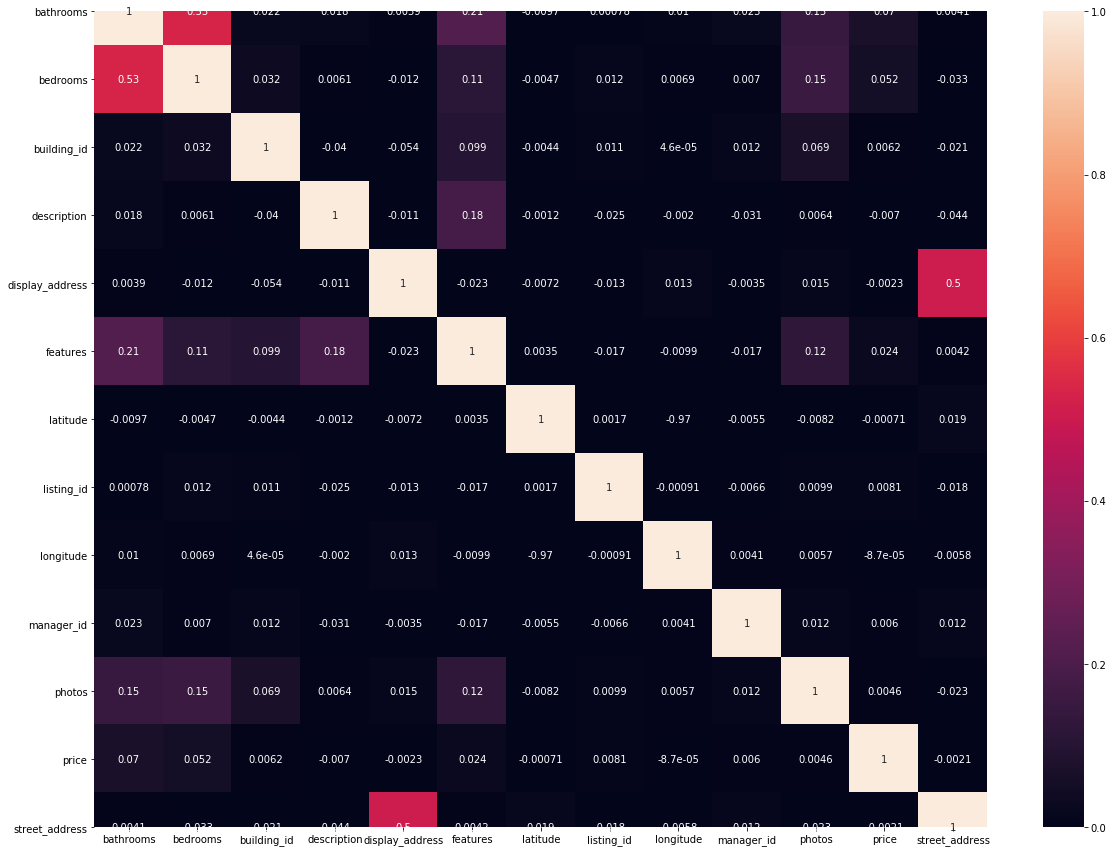

In [10]:
plt.figure(figsize = (20,15))
corrMatrix = trainData.corr()
sn.heatmap(corrMatrix,vmin = 0, vmax = 1, annot = True)
plt.show()

In [11]:
target_num_map = {'high':0, 'medium':1, 'low':2}
X_train = trainData[trainData.columns[~trainData.columns.isin(['interest_level'])]]
Y_train = np.array(trainData['interest_level'].apply(lambda x: target_num_map[x]))

X_test = testData

extract more impotance features:

In [13]:
def featureImportance( X, Y, firstNo = 100):
        from sklearn.ensemble import ExtraTreesClassifier
        model = ExtraTreesClassifier()
        model.fit(X, Y)
        importance = np.array(model.feature_importances_)
        select = (importance > sorted(importance, reverse = True))
        dataset_sel = X.iloc[:, select]
        return (importance, dataset_sel)
    
_,X_featureImportance = featureImportance(X_train,Y_train)
ImportanceHeaders = X_featureImportance.columns.tolist()

normalize and standardize data attributes:

In [14]:
normalized_X_train = preprocessing.normalize(X_featureImportance)
normalized_X_test = preprocessing.normalize(X_test[ImportanceHeaders])

standardized_X_train = preprocessing.scale(X_featureImportance)
standardized_X_test = preprocessing.scale(X_test[ImportanceHeaders])

train model:

In [16]:
X_train, X_val, y_train, y_val = train_test_split(normalized_X_train, Y_train, test_size = 0.3, random_state = 7)
clf1 = GradientBoostingClassifier(n_estimators = 200, max_depth = 9)
clf2 = AdaBoostClassifier(n_estimators = 200)
clf3 = RandomForestClassifier(n_estimators = 300)

estimators = [('gb', clf1), ('ab', clf2), ('rf', clf3)]
vclf = VotingClassifier(estimators = estimators, voting = 'soft', n_jobs = -1)

vclf.fit(X_train, y_train)
y_val_pred = vclf.predict_proba(X_val)
accuracy = log_loss(y_val, y_val_pred)
print("log_loss: %.2f%%" % (accuracy))

log_loss: 0.77%


test model:

In [21]:
y = vclf.predict_proba(normalized_X_test)

out = pd.DataFrame()
out['listing_id'] = X_test['listing_id']
for i in ['high', 'medium', 'low']:
    out[i] = y[:, target_num_map[i]]
out.to_csv('outputLast.csv', index=False)